## Importação

In [1]:
import numpy as np
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import Normalizer, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

## Pegando DataSet

In [2]:
df = pd.read_csv('./SRC/titanic/train.csv', sep=',')
df_test = pd.read_csv('./SRC/titanic/test.csv', sep=',')
y_test = pd.read_csv('./SRC/titanic/gender_submission.csv', sep=',')

In [3]:
y_test = y_test['Survived']

## Análise dos dados

Primeiro passo é excluir colunas que em nenhuma hipótese ferão diferença

In [4]:
df = df.drop(columns=['PassengerId', 'Name'])
df_test = df_test.drop(columns=['PassengerId', 'Name'])

Segundo passo foi transformar todos os dados categoricos em numericos

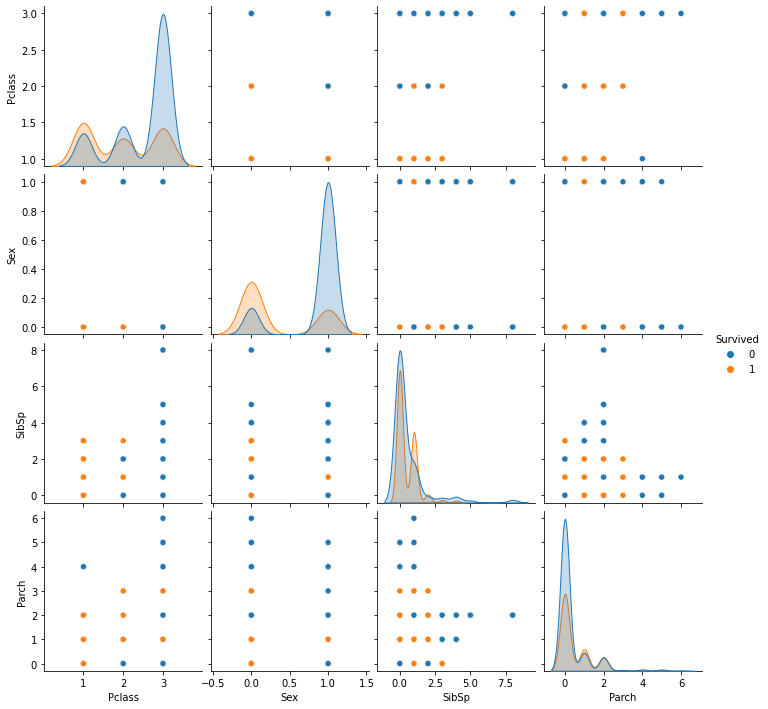

In [40]:
sb.pairplot(df, hue='Survived')

<AxesSubplot:xlabel='Embarked', ylabel='count'>

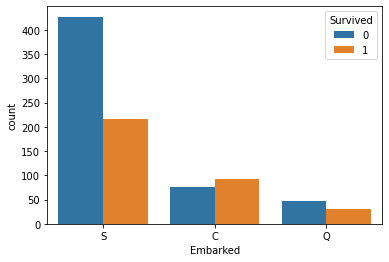

In [6]:
sb.countplot(data=df, x='Embarked', hue='Survived')

<AxesSubplot:xlabel='Pclass', ylabel='count'>

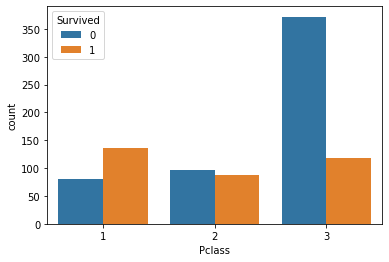

In [7]:
sb.countplot(data=df, x='Pclass', hue='Survived')

Depois de alguns da análise, percebi que alguns dados não são tão relevantes(Fare, Ticket), alguns dados são redundantes(Embarked, a diferença no plot é devido alguns passageiros de primeira classe embarcaram em ponto específico) e por ultimos os dados da Cabin são muito importantes, porém escassos, farei teste substituindo os faltantes por um valor 0 e outro excluindo esta coluna.

In [8]:
df = df.drop(columns=['Embarked', 'Ticket', 'Fare'])
df_test = df_test.drop(columns=['Embarked', 'Fare', 'Ticket'])

## Tratamento de dados

In [9]:
df = df.fillna('0')
df_test = df_test.fillna('0')

In [10]:
labelencoder = LabelEncoder()

df['Sex'] = labelencoder.fit_transform(df['Sex'])
df_test['Sex'] = labelencoder.fit_transform(df_test['Sex'])
df['Cabin'] = labelencoder.fit_transform(df['Cabin'])
df_test['Cabin'] = labelencoder.fit_transform(df_test['Cabin'])

In [11]:
df = df.drop(columns=['Cabin'])
df_test = df_test.drop(columns=['Cabin'])

In [12]:
X_train, X_test = df.drop(columns=['Survived']), df_test
y_train = df['Survived']


In [13]:
def normalizar(X_train, X_test):
    transformer = Normalizer().fit(X_train)
    X_train = transformer.transform(X_train)
    transformer = Normalizer().fit(X_test)
    X_test = transformer.transform(X_test)
    return X_train, X_test

## Treinando modelos

In [14]:
X_train, X_test = normalizar(X_train, X_test)

### KNN

In [15]:
modelo = KNeighborsClassifier(n_neighbors=5)
modelo.fit(X_train, y_train)

KNeighborsClassifier()

In [16]:
y_predict = modelo.predict(X_test)
print('Precisao')
print(accuracy_score(y_test, y_predict))

Precisao
0.8564593301435407


### SVC

In [17]:
modelo = SVC()
modelo.fit(X_train, y_train)

SVC()

In [18]:
y_predict = modelo.predict(X_test)
print('Precisao')
print(accuracy_score(y_test, y_predict))

Precisao
0.69377990430622


### Random Forest

In [19]:
modelo = RandomForestClassifier()
modelo.fit(X_train, y_train)

RandomForestClassifier()

In [20]:
y_predict = modelo.predict(X_test)
print('Precisao')
print(accuracy_score(y_test, y_predict))

Precisao
0.8301435406698564


### Decision Tree

In [21]:
modelo = DecisionTreeClassifier()
modelo.fit(X_train, y_train)

DecisionTreeClassifier()

In [22]:
y_predict = modelo.predict(X_test)
print('Precisao')
print(accuracy_score(y_test, y_predict))

Precisao
0.8253588516746412


### MLP

In [23]:
modelo = MLPClassifier(max_iter=2000)
modelo.fit(X_train, y_train)

MLPClassifier(max_iter=2000)

In [24]:
y_predict = modelo.predict(X_test)
print('Precisao')
print(accuracy_score(y_test, y_predict))

Precisao
0.9234449760765551


## Verificando melhor modelo

### Tentando estabilizar o MLP

In [25]:
kf = KFold(n_splits=4, shuffle=True)
for train_index, test_index in kf.split(X_train):
    X1, X2 = X_train[train_index], X_train[test_index]
    y1, y2 = y_train[train_index], y_train[test_index]
    modelo = MLPClassifier(max_iter=2000)
    modelo.fit(X1, y1)
    y_predict = modelo.predict(X2)
    print('Precisao')
    print(accuracy_score(y2, y_predict))

Precisao
0.7623318385650224
Precisao
0.8340807174887892
Precisao
0.757847533632287
Precisao
0.8243243243243243


### Random search

In [26]:
parameters = {
    'solver': ['sgd', 'adam'],
    'activation': ['relu', 'tanh','identity', 'logistic']
}
clf = GridSearchCV(MLPClassifier(max_iter=1000), parameters)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9258373205741627

### Tentando melhorar o RandomForest

In [37]:
lista = [x for x in range(300)]
parametros = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': lista
}
rs = RandomizedSearchCV(RandomForestClassifier(), parametros)
rs.fit(X_train, y_train)
y_pred = rs.predict(X_test)
accuracy_score(y_test, y_pred)

0.8444976076555024

## Salvando o melhor modelo

In [27]:
import os
save_models_path = './results'
if not os.path.exists(save_models_path):
    os.mkdir(save_models_path)

In [28]:
import joblib
import glob

O melhor classificador foi o MLP, ele será salvo.

In [29]:
filename = save_models_path+'/titanic.pkl'
joblib.dump(clf,filename)

['./results/titanic.pkl']

In [30]:
modelo_load = joblib.load('./results/titanic.pkl')

In [31]:
accuracy_score(y_test, modelo_load.predict(X_test))

0.9258373205741627